In [82]:
import straph as sg
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (12,9)

# Temporal Network Analysis: High School Dataset, Interactions among Students

First, we download and parse the [High School 2013 dataset](http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/). It is the temporal network of interactions between students of 5 classes during 7 days in a high school in Marseille, France in 2013. An interaction consists in a physical proximity between two students, captured by a sensor.

In [3]:
import urllib.request
import gzip

def download(url, file_name):
    # get request
    with urllib.request.urlopen(url) as response:
        # uncompress file
        with gzip.GzipFile(fileobj=response) as uncompressed, open(file_name, 'wb') as out_file:
            file_content = uncompressed.read()
            out_file.write(file_content)

In [4]:
url = "http://www.sociopatterns.org/wp-content/uploads/2015/07/High-School_data_2013.csv.gz"
file_name = "high_school_2013.csv"
download(url, file_name)

In [5]:
entry_format = {"u_pos": 1, "v_pos": 2, "t_pos": 0}
config = {"delimiter": " ", "ignore_header": False, "nodes_to_label": True, "time_is_datetime": False,
          "link_duration": 60}
sg.sort_csv(file_name, entry_format, **config)
S = sg.parser(input_file=file_name,
           input_format='csv',
           entry_format=entry_format,
           output_file="high_school_2013",
           output_format='sg',
           **config)

Writing CSV: 100%|█████████████████████████████████████████████████████████| 188508/188508 [00:00<00:00, 529154.05it/s]
Parsing CSV: 188508it [00:00, 193292.68it/s]                                                                           


Let's print a short description of this dataset.

In [6]:
S.describe()

Nb of Nodes :  327
Nb of segmented nodes :  47720.0
Nb of links :  5818
Nb of segmented links :  46025.0
Nb of event times :  7360


There's $327$ students interacting $46025$ times among each other at $7360$ distinct event times. Let's learn more.

## Visualisation

This dataset contains many interactions, an overall visualisation may not shed interesting patterns.

<AxesSubplot:xlabel='t', ylabel='Nodes'>

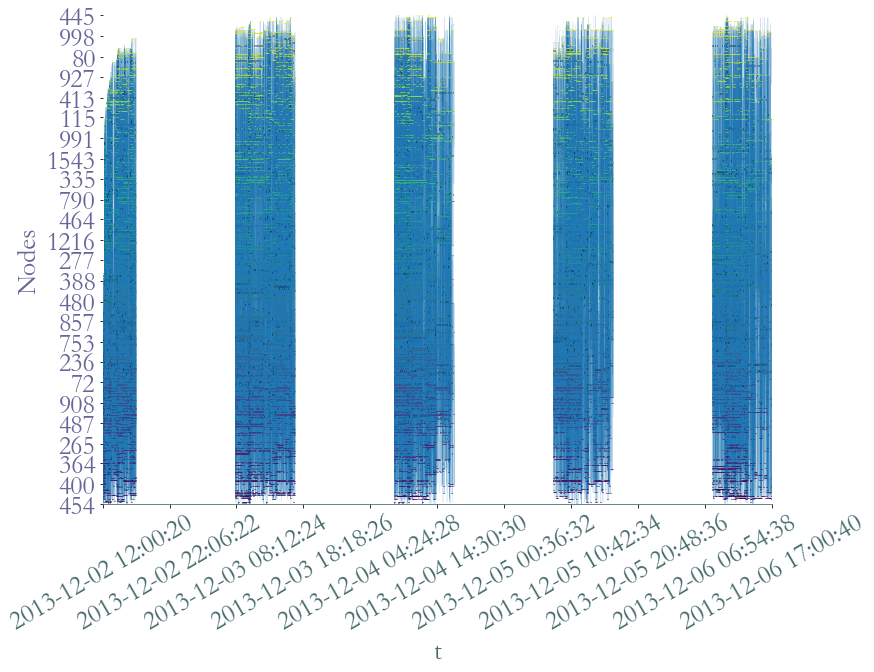

In [7]:
S.plot(lw_nodes = 1, lw_links = 0.5, timestamp = True)

<AxesSubplot:xlabel='t', ylabel='Nodes'>

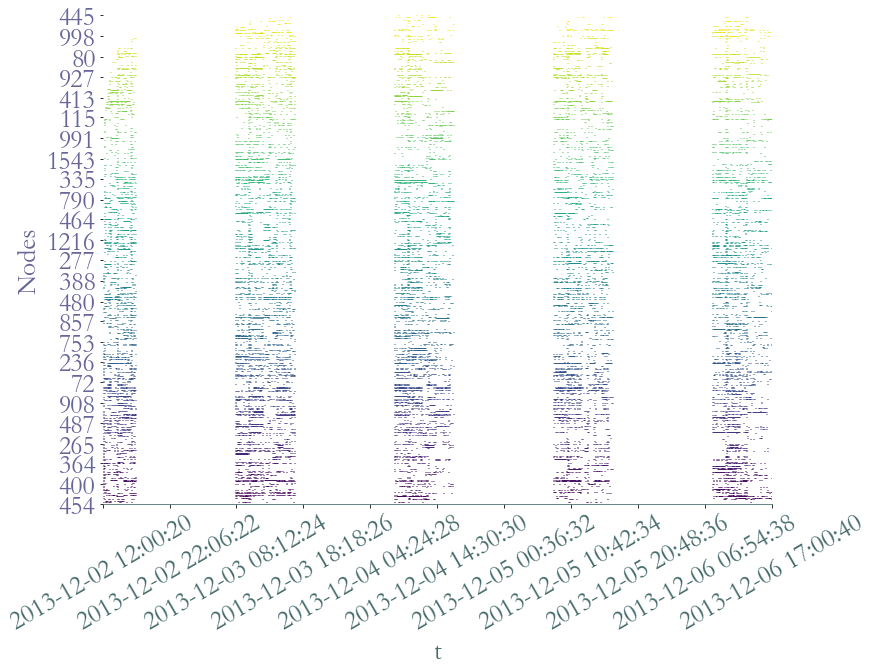

In [8]:
S.plot(lw_nodes = 1, lw_links = 0.5, timestamp = True, plot_links = False)

However, we can observe the distinct five days of recording. We can observe that nodes, which are present only if they are involved in at least an interaction, are not homogenously active during school time. There seems to be periods of intense activity in the middly of the day as well as during the during the morning. It seems coherent with breaks time.

The node and link weight over time should confirm this observation.

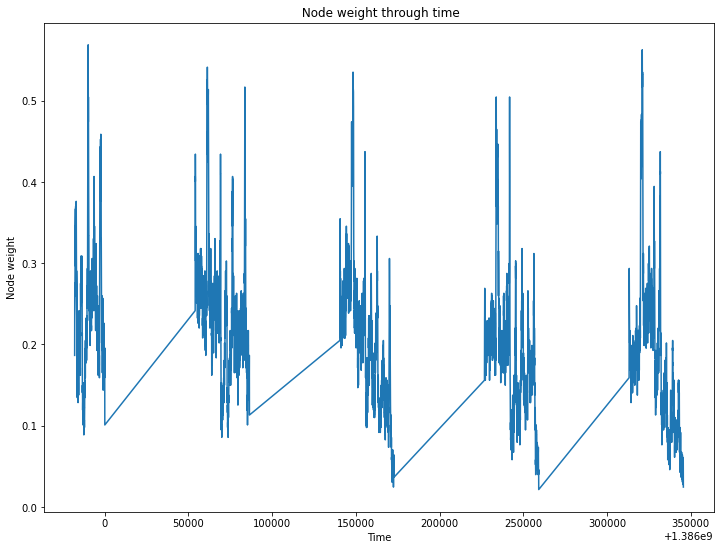

In [9]:
_ = S.plot_node_weight()

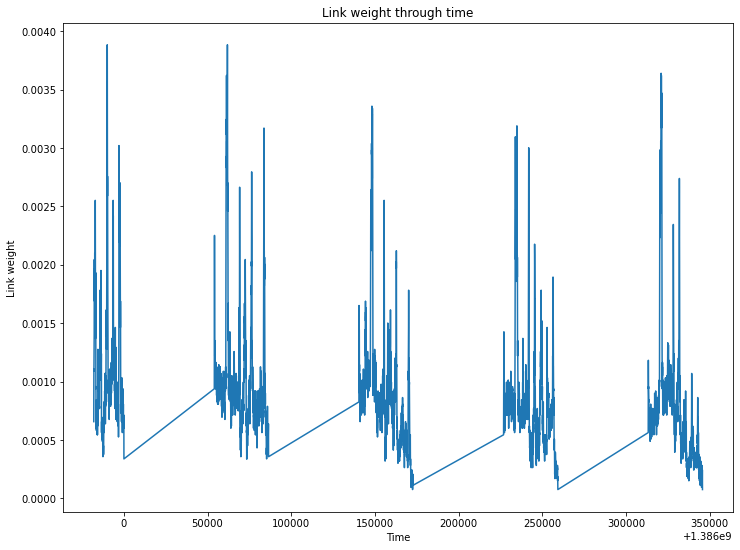

In [10]:
_ = S.plot_link_weight()

We can remove the interactions between students and instead, display their degree over time. We also focus on a particular day in order to improve lisibility.

In [11]:
from datetime import datetime
t0,t1 = datetime.fromisoformat("2013-12-03 07:00:00"),datetime.fromisoformat("2013-12-03 18:00:00")
S2 = S.induced_substream_by_time_window([t0.timestamp(),t1.timestamp()])

<AxesSubplot:xlabel='t', ylabel='Nodes'>

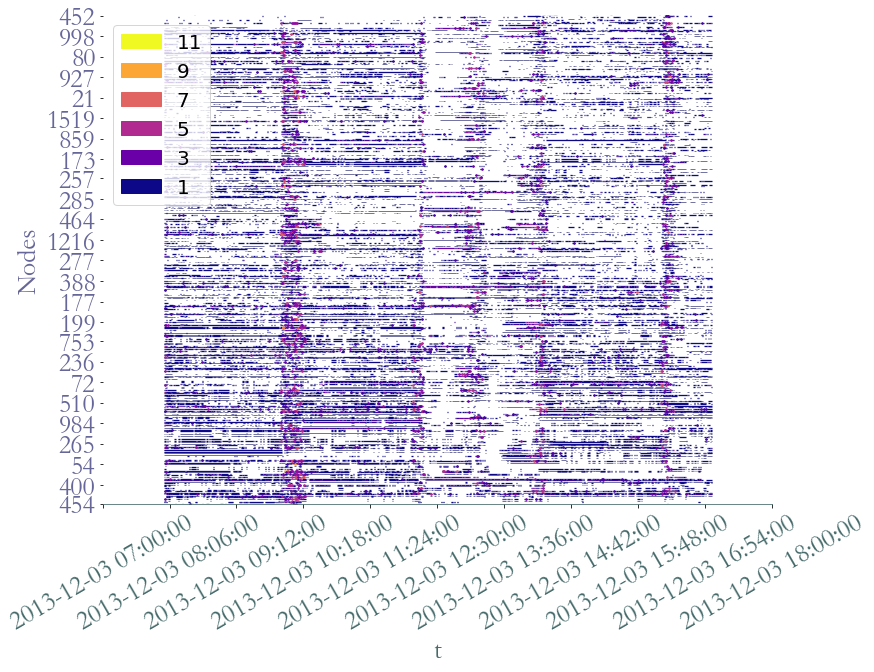

In [12]:
S2.plot(clusters = S.degrees_partition(),plot_links = False,lw_nodes = 1, timestamp = True )

We clearly observe periods on intense activy around $9$am for $15$ minutes, probably a break time, at $11$am, $12$am and $1$pm, probably corresponding to the lunch period, and a last time aroud $3$pm, corresponding to the afternoon break.

## Largest group of friend

Let us focus on the largest group of friends in this high school. We define this group
as the largest group where each individual interacts with every other. We point out
that we do not prioritize a period of time over another, break time and class time
are considered equally. In other words, it is about finding the largest clique with the
longest duration.

### 1. Largest and Longest *Clique*

In [20]:
cliques = S.all_cliques()
print("Maximum clique size: ", max(cliques.keys()))
print("Cliques of size ",max(cliques), ": ",cliques[max(cliques)])

Maximum clique size:  6
Cliques of size  6 :  [[(1386148020.0, 1386148020.0, 173), (1386148020.0, 1386148020.0, 125), (1386148020.0, 1386148020.0, 99), (1386148020.0, 1386148020.0, 169), (1386148020.0, 1386148020.0, 176), (1386148020.0, 1386148020.0, 316)], [(1386148020.0, 1386148040.0, 173), (1386148020.0, 1386148040.0, 125), (1386148020.0, 1386148040.0, 99), (1386148020.0, 1386148040.0, 169), (1386148020.0, 1386148040.0, 176), (1386148020.0, 1386148040.0, 316)], [(1386148040.0, 1386148040.0, 173), (1386148040.0, 1386148040.0, 99), (1386148040.0, 1386148040.0, 169), (1386148040.0, 1386148040.0, 316), (1386148040.0, 1386148040.0, 125), (1386148040.0, 1386148040.0, 176)]]


In [47]:
def clique_max_members_and_duration(cliques, clique_size):
    counter_clique = {}
    for c in cliques[clique_size]:
        t0 ,t1 ,_ = c[0]
        # Get distinct groups in cliques
        members = tuple(sorted([n for _,_,n in c]))
        # Sum total duration per group
        if members in counter_clique :
            counter_clique[members] += t1 -t0
        else :
            counter_clique[members] = t1 - t0
    suspects, duration = max(counter_clique.items() , key = lambda x:x[1])
    return suspects, duration

In [48]:
clique_max_members_and_duration(cliques, 6)

((99, 125, 169, 173, 176, 316), 20.0)

The maximum clique size is $6$, there is only one $6$-clique and its total duration is $20$ seconds. We consider its duration as too short considering the time window of the stream graph. 

In [49]:
clique_max_members_and_duration(cliques, 5)

((144, 165, 267, 268, 275), 140.0)

Likewise, the longest $5$-clique lasts only for $140$ seconds, also too short relatively to the time window of the dataset. We focus on $4$-cliques.

In [50]:
members, duration = clique_max_members_and_duration(cliques, 4)
members = [S.node_to_label[n] for n in members]
members, duration

(['275', '312', '612', '886'], 3300.0)

We can plot this clique in order to observe interactions between its members through time.

<AxesSubplot:xlabel='t', ylabel='Nodes'>

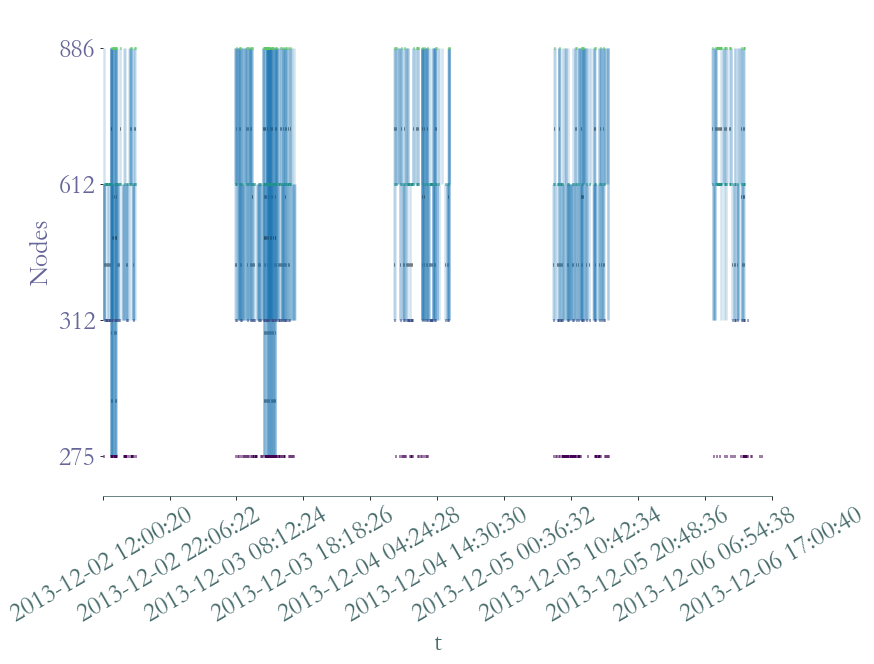

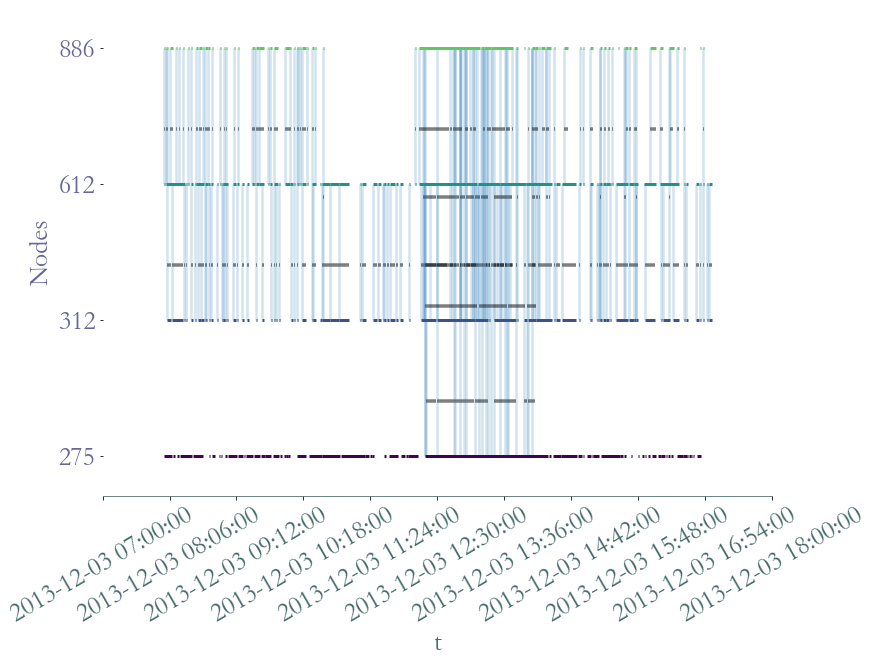

In [52]:
S3 = S.induced_substream_by_nodes(members)
S3.plot(timestamp = True, arrivals_marker=False)
# The same plot but on the second day.
S4 = S2.induced_substream_by_nodes(members)
S4.plot(timestamp = True, arrivals_marker=False)

Nodes $886$, $612$ and $312$ are probably in the same class whereas node $275$ only shared two lunch breaks with its friends, it probably means that $275$ is in another class.

### 2. Largest and Longest *Strongly Connected Component*

The assumption that a group of friends is necessary a clique may be a bit too strong,
given the conditions of the interactions’ recording. Nevertheless, we can suppose that
this group of friends gather frequently and when it happens they are connected with
each other: they are in the same strongly connected component. Let us find the
groups of nodes of at least 4 members which are strongly connected for the longest
period of time.

In [53]:
def scc_max_members_and_duration(scc, min_scc_size):
    counter_scc = {}
    for c in scc:
        t0 ,t1 ,_ = c[0]
        # Get distinct groups in scc
        members = tuple(sorted([n for _,_,n in c]))
        # Sum total duration per group
        if len(members) >= min_scc_size:
            if members in counter_scc :
                counter_scc[members] += t1 -t0
            else :
                counter_scc[members] = t1 - t0
    suspects, duration = max(counter_scc.items(), key = lambda x:x[1])
    return suspects, duration

In [54]:
scc = S.strongly_connected_components(format = "cluster")
members, duration = scc_max_members_and_duration(scc, 4)
members = [S.node_to_label[n] for n in members]
members, duration

(['3', '884', '339', '147'], 9620.0)

We have found a component of size $4$ in which members interact together for a total of $9620$ seconds. Which is higher than the result of the *clique* approach. Let's plot interactions between these students.

<AxesSubplot:xlabel='t', ylabel='Nodes'>

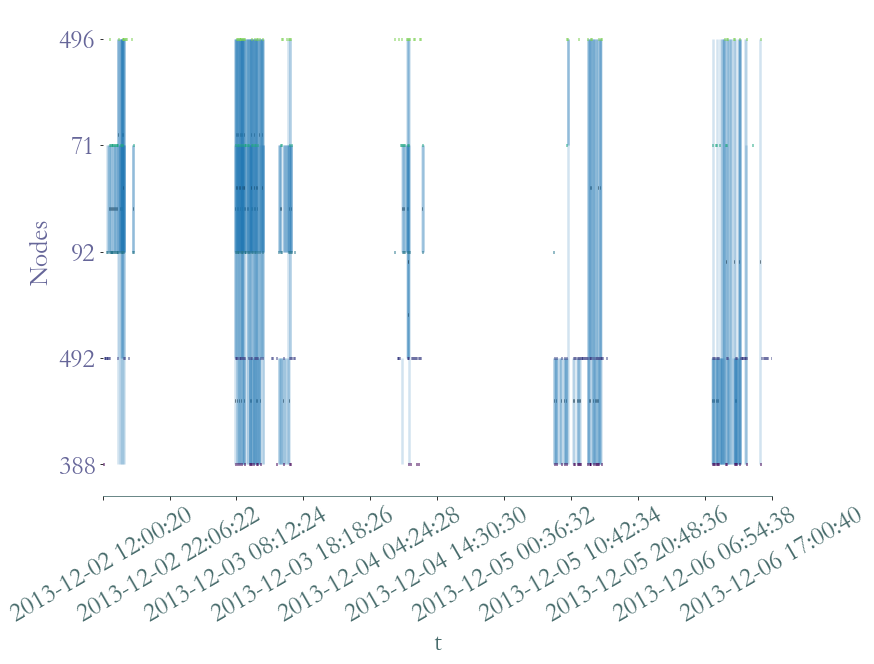

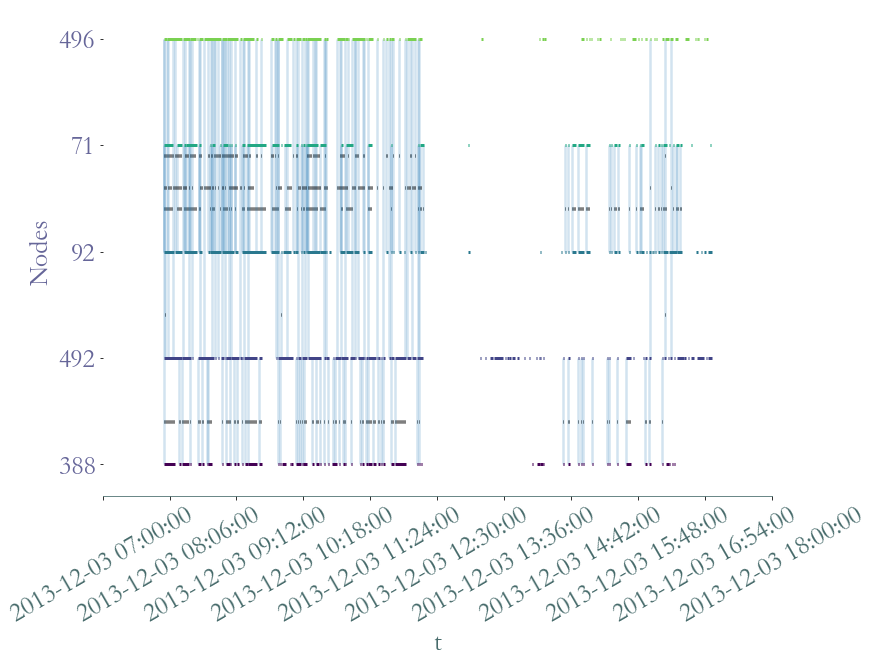

In [116]:
S3 = S.induced_substream_by_nodes(members)
S3.plot(timestamp = True, arrivals_marker=False)
# The same plot but on the second day.
S4 = S2.induced_substream_by_nodes(members)
S4.plot(timestamp = True, arrivals_marker=False)

It's not easy to see if each student has interacted with the others individualy, let's plot the aggregated graph.

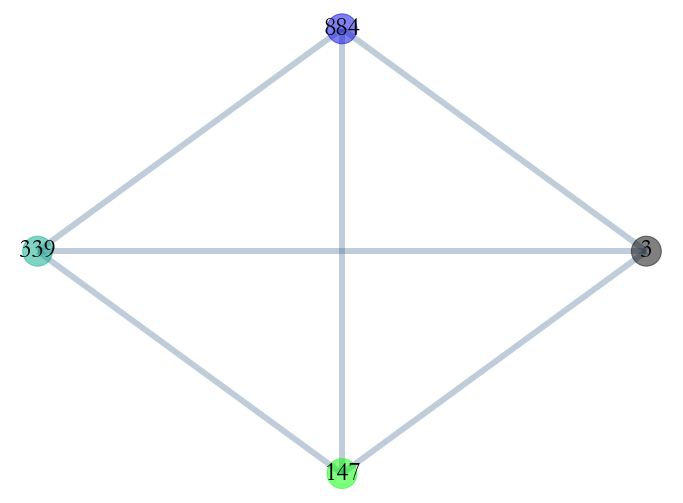

In [57]:
_ = S3.plot_aggregated_graph()

All links exists between theses students, there's a clique in the aggregated graph.

We have shown that with the help of ``Straph`` it is possible to bring a (partial) answer to
this complex question with only a dozen lines of code. Other approaches based on
Straph functionalities, such as k-cores, could have been used to address this problem.
Another solution consists in finding the longest and densest substream. However this
problem has a huge complexity and no known algorithm exists to solve it.

## The most "popular" student

Another common task is finding the "central" nodes of the dataset, and analyse their behaviour relatively to the other.

### 1. *Degree* Approach

We start by observing the degree distribution of nodes in the dataset.
We recall that a node's degree in stream graph theory is defined by:
$$ d(v) = \frac{|N(v)|}{|T|} = \sum_{u \in V} \frac{|T_{uv}|}{|T|}$$

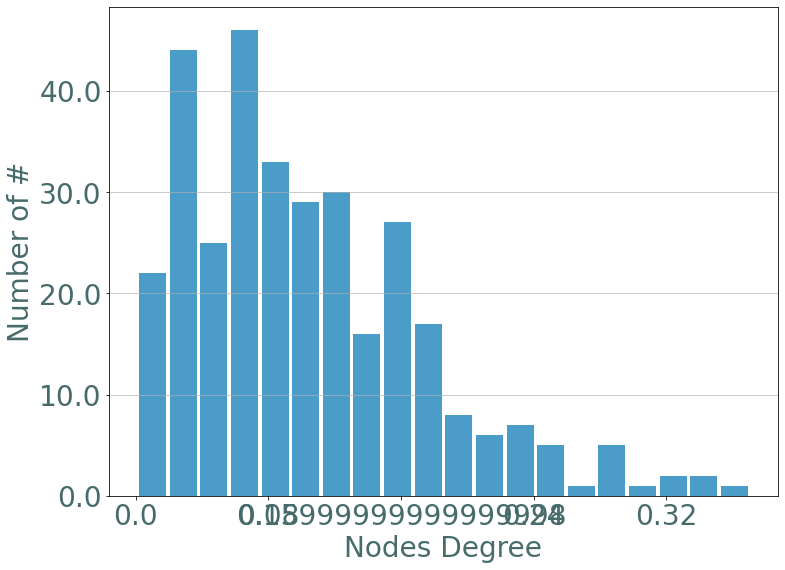

In [58]:
degrees = S.degrees()
_ = sg.hist_plot(list(degrees.values()), xlabel = "Nodes Degree", bins = 20)

There's only a few nodes with a high degree, let's select them.

In [62]:
members = [n for n,v in degrees.items() if v > 0.3]
members = [S.node_to_label[n] for n in members]
members

['255', '1359', '122', '3', '884']

We can verify whether these nodes are the same that have the most number of distinct neighbors. Which is their degree in the aggregated graph.


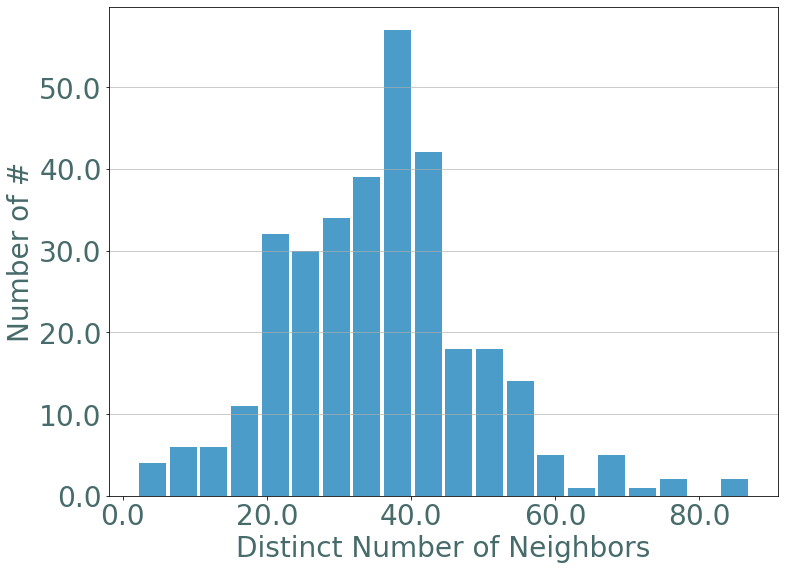

In [66]:
nb_neighbors = S.nb_neighbors()
_ = sg.hist_plot(list(nb_neighbors.values()), xlabel = "Distinct Number of Neighbors", bins = 20)

In [69]:
members2 = [n for n,v in nb_neighbors.items() if v > 60]
members2 = [S.node_to_label[n] for n in members2]
members2

['9',
 '45',
 '275',
 '176',
 '1359',
 '376',
 '1518',
 '1332',
 '605',
 '106',
 '272',
 '674',
 '232']

In [70]:
set(members) & set(members2)

{'1359'}

There's only one node that appears in both category, let's plot its instant degree over time and compare it to the mean of the instant degree of the other nodes.

In [144]:
d_t = S.degree_over_time()
label_to_node = {v:k for k,v in S.node_to_label.items()}
target = label_to_node['1359']

len index : 21706  len event times : 21706


In [145]:
D = pd.DataFrame.from_dict(d_t, orient = 'index')
mean_d_t = D.mean(axis = 0)

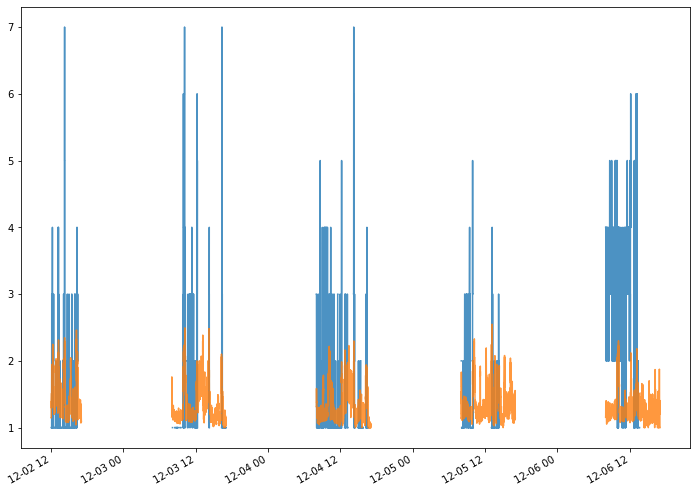

In [152]:
_ = d_t[target].plot(alpha = 0.8)
_ = mean_d_t.plot(alpha = 0.8)

### 2. Katz Centrality

The Katz centrality of a node is a measure of centrality in a network. It used to measure the relative degree of influence of an actor (or node) within a social network.

In [148]:
from networkx.algorithms import katz_centrality
katz = S.graph_property(katz_centrality, format = "signal")
D = pd.DataFrame.from_dict(katz,orient = 'index')
new_target = D.sum(axis = 1, skipna = True).argmax()
mean_katz_t = D.mean(axis = 0)

Let's plot the new target's katz centrality over time versus the mean value of katz centrality of the other nodes over time.

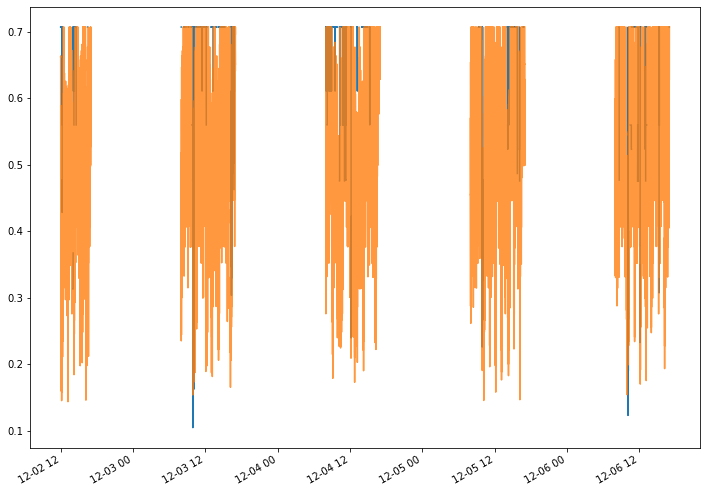

In [155]:
_ = katz[new_target].plot(alpha = 1)
_ = mean_katz_t.plot(alpha = 0.8)

In this use case we have quickly shown how ``Straph`` can be used for the description and modelisation of real world data.

In [ ]:
import os
os.remove("high_school_2013.csv")